In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
from IPython.display import Image
#from IPython.display import clear_output
#import sklearn
import time
#import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# data pre-processing
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection._split import BaseShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# prediction models
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

In [2]:
from os import listdir
from os.path import isfile, join

class FilePathManager:
    def __init__(self, local_dir: str):
        self.local_dir = local_dir
    
    def retrieve_full_path(self):
        return os.getcwd()+'/'+self.local_dir

In [3]:
class Loader:
    df = pd.DataFrame()
    
    #@abstractmethod
    def load_data(self, file_name):
        pass
    
    #@abstractmethod
    def get_df(self):
        pass
    
    def size(self):
        return len(self.df)

In [8]:
from typing import Callable
 
class CSVLoader(Loader):
    def __init__(self, file_path_manager: FilePathManager):
        self.file_path_manager = file_path_manager
        
    def load_data(self, _prepare_data: Callable[[pd.DataFrame], pd.DataFrame] = None):
        self.df = pd.read_csv(self.file_path_manager.retrieve_full_path(), compression='gzip')
        if _prepare_data:
            self.df = _prepare_data(self.df)
    
    def get_df(self):
        return self.df;
    
    def size(self):
        return len(self.df)  

In [9]:
def clean_data(df):
    df['# label'] = df['# label'].astype(int)
    return df

In [10]:
loader = CSVLoader(FilePathManager('all_train.csv.gz'))
loader.load_data(clean_data)
df = loader.get_df()

## EDA

In [11]:
df.head()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [12]:
df['# label'].value_counts()

1    3500879
0    3499121
Name: # label, dtype: int64

In [13]:
df['# label'].value_counts(normalize=True)

1    0.500126
0    0.499874
Name: # label, dtype: float64

### Scaling and Skew
Need to scale feature 'mass'.  Other features are already scaled or pretty close.

Several features are highly skewed with min or max values > 4 standard devations from the mean

In [44]:
feature_summary = df.iloc[:, 1:29].describe().T
feature_summary

,count,mean,std,min,25%,50%,75%,max
f0,7000000.0,0.016125,1.004417,-1.960549,-0.728821,-0.039303,0.690080,4.378282
f1,7000000.0,0.000477,0.997486,-2.365355,-0.733255,0.000852,0.734783,2.365287
f2,7000000.0,0.000027,1.000080,-1.732165,-0.865670,0.000320,0.865946,1.732370
f3,7000000.0,0.010561,0.995600,-9.980274,-0.609229,0.019633,0.679882,4.148023
f4,7000000.0,-0.000105,0.999867,-1.732137,-0.865802,-0.000507,0.865765,1.731978
f5,7000000.0,0.002766,1.000957,-1.054221,-1.054221,-0.005984,0.850488,4.482618
f6,7000000.0,0.018160,0.986775,-3.034787,-0.756609,-0.149953,0.768669,3.720345
f7,7000000.0,0.000025,0.996587,-2.757853,-0.701415,-0.000107,0.701319,2.758590
f8,7000000.0,0.000435,1.000007,-1.732359,-0.865654,0.001385,0.866598,1.731450
f9,7000000.0,-0.006870,1.001938,-1.325801,-1.325801,0.754261,0.754261,0.754261


#### Higly skewed features

In [53]:
right_skew = feature_summary.loc[feature_summary['max'] > feature_summary['mean'] + feature_summary['std']*4]
left_skew = feature_summary.loc[feature_summary['min'] < feature_summary['mean'] - feature_summary['std']*4]
skew = pd.concat([right_skew.T, left_skew.T], axis=0, join='outer')
skew.head(8)

,f0,f3,f5,f10,f14,f18,f22,f23,f24,f25,f26
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,1.612528e-02,1.056081e-02,2.765919e-03,1.754267e-02,1.724634e-02,1.164789e-02,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02
std,1.004417e+00,9.956003e-01,1.000957e+00,9.941511e-01,9.994654e-01,1.002725e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01
min,-1.960549e+00,-9.980274e+00,-1.054221e+00,-2.835563e+00,-2.454879e+00,-1.728284e+00,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00
25%,-7.288206e-01,-6.092291e-01,-1.054221e+00,-7.237266e-01,-6.996179e-01,-7.423630e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01
50%,-3.930319e-02,1.963316e-02,-5.983562e-03,-1.285732e-01,-9.749269e-02,-8.992496e-02,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02
75%,6.900799e-01,6.798818e-01,8.504885e-01,6.478635e-01,6.347052e-01,6.423185e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01
max,4.378282e+00,4.148023e+00,4.482618e+00,4.639335e+00,5.535799e+00,5.866367e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00


#### No major outliers, just skewed data

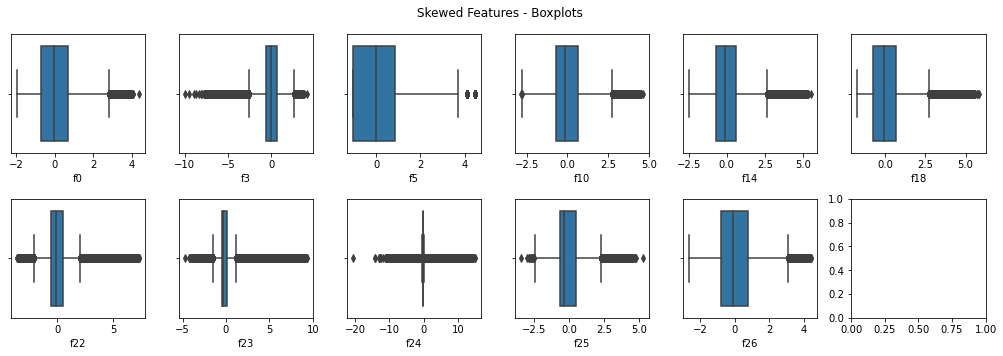

In [55]:
fig, axes = plt.subplots(2, 6, figsize=(14, 5))
fig.suptitle('Skewed Features - Boxplots')
for i,j in zip(skew.columns, range(11)):
    sns.boxplot(ax = axes[int(j/6), j%6], x = df[i])

fig.tight_layout()

## Modeling Prep

In [15]:
class BaseImputer:
    #@abstractmethod
    def fit(self, X, y=None):
        pass
    
    #@abstractmethod
    def transform(self, X):
        pass

class BaseModel:
    #@abstractmethod
    def fit(self, X, y, sample_weight=None):
        pass
    
    #@abstractmethod
    def predict(self, X):
        pass

In [21]:
class Modeling:
    _X_train_fitted = None
    _X_test_fitted = None
    _y_train = None
    _y_test = None
    _y_preds = None
    
    def __init__(self, data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None):
        self._data = data
        self._target_name = target_name
        self._shuffle_splitter = shuffle_splitter
        self._imputer = imputer
        self._model = model
        self._X, self._y = self._split_data()
        self._scaler = scaler
        
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
     
    @property
    def X_train(self):
        return self._X_train_fitted
    
    @property
    def X_test(self):
        return self._X_test_fitted
    
    @property
    def y_train(self):
        return self._y_train
    
    @property
    def y_test(self):
        return self._y_test
    
    @property
    def y_preds(self):
        return self._y_preds
    
    def _split_data(self):
        X = self._data.copy()
        return X.drop([self._target_name], axis=1) , X[self._target_name]
    
    def _shuffle_split(self):
        X = self.X
        y = self.y
        for train_index, test_index in self._shuffle_splitter.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        return X_train, X_test, y_train, y_test
    
    def _fit_imputer(self, train):
        if self._imputer is not None:
            self._imputer.fit(train)
    
    def _fit_scaler(self, train):
        if self._scaler is not None:
            self._scaler.fit(train)
    
    def _impute_data(self, X: pd.DataFrame):
        if self._imputer is not None:
            return pd.DataFrame(self._imputer.transform(X), columns = self.X.columns, index = X.index)
        return X
    
    def _scale_data(self, X: pd.DataFrame):
        if self._scaler is not None:
            X = pd.DataFrame(self._scaler.transform(X), columns = self._X.columns)
        return X
    
    def prepare(self):
        X_train, X_test, y_train, y_test = self._shuffle_split()   
        self._fit_imputer(X_train)
        X_train = self._impute_data(X_train)
        X_test = self._impute_data(X_test)
        self._fit_scaler(X_train)
        self._X_train_fitted = self._scale_data(X_train)
        self._X_test_fitted = self._scale_data(X_test)
        self._y_train = y_train
        self._y_test = y_test
        
    def prepare_and_train(self):
        self.prepare()
        return self.train()
        
    def train(self): #, epoch=None, batch=None
        self._model.fit(self.X_train, self.y_train) #, batch_size=batch, epochs=epoch
        self._y_preds = self._model.predict(self.X_train)
        
        return self.metrics(self.y_train, self.y_preds)
        
    def test(self):
        return self.metrics(self.y_test, self._model.predict(self.X_test))
       
        
    def metrics(self, y_true = None, y_pred = None):
        pass

In [22]:
class ClassificationModeling(Modeling):
    def __init__(self, 
                 data: pd.DataFrame, 
                 target_name: str, 
                 shuffle_splitter: BaseShuffleSplit, 
                 imputer: BaseImputer, 
                 model: BaseModel, 
                 scaler = None,
                 beta: int = 1,
                 classification: str = 'binary'):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler)
        self.beta = beta
        self.classification = classification
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
        return ({'matrix': confusion_matrix(y_true, y_pred), 
            'accuracy': accuracy_score(y_true, y_pred), 
            'precision': precision_score(y_true, y_pred, average=self.classification), 
            'recall': recall_score(y_true, y_pred, average=self.classification),
             'f1': f1_score(y_true, y_pred),
            'f{}'.format(self.beta) : fbeta_score(y_true, y_pred, average=self.classification, beta=self.beta) } )

In [23]:
class NNClassificationModeling(ClassificationModeling):
    def __init__(self, 
             data: pd.DataFrame, 
             target_name: str, 
             shuffle_splitter: BaseShuffleSplit, 
             imputer: BaseImputer, 
             model: BaseModel, 
             scaler = None,
             beta: int = 1,
             classification: str = 'binary', tb_callback = TensorBoard(log_dir="logs/", histogram_freq=1)):
        super().__init__(data, target_name, shuffle_splitter, imputer, model, scaler, beta, classification)
        self.tb_callback=tb_callback
        
        
    def train(self, epoch, batch):
        logDir = "logs/{epoch}-{batchsize}-{time}".format(epoch=epoch, batchsize=batch, time=time.time())
        self.tb_callback.log_dir = logDir
        self._model.fit(self.X_train, self.y_train, batch_size=batch, epochs=epoch, validation_data=(self.X_test, self.y_test), callbacks=[self.tb_callback])
        self._y_preds = self._model.predict(self.X_train)
        return self.metrics(self.y_train, self.y_preds)
    
    def metrics(self, y_true = None, y_pred = None):
        if y_true is None and y_pred is None:
            y_true = self.y_train
            y_pred = self.y_preds
            
        y_pred = pd.Series(y_pred.reshape((y_pred.shape[1], y_pred.shape[0]))[0], index=y_true.index)
        y_pred = pd.Series( (y_pred>0.5).astype(int), index=y_true.index)
        return super().metrics(y_true,y_pred)
    

## Baseline Model - Logistic Regression

In [29]:
baseline = ClassificationModeling(df,'# label',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           None,
                           LogisticRegression(penalty='l1', solver='saga', random_state=12343),
                           StandardScaler(), beta=2)

baseline.prepare()

In [35]:
baseline_results = pd.DataFrame()

for i in [0.0001, 0.0005, 0.001, .005, 1, 100]:
    baseline.model.C = i
    baseline_results = baseline_results.append({"C": i,
                                               "Train Accuracy": round( baseline.train()['accuracy'], 4),
                                               "Test Accuracy": round( baseline.test()['accuracy'], 4)},
                                              ignore_index=True)

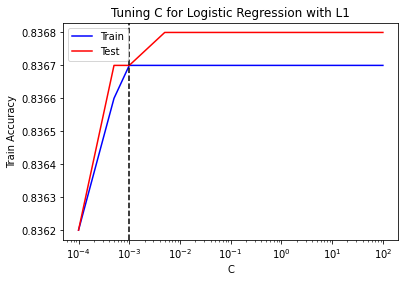

In [36]:
sns.lineplot(data=baseline_results, x='C', y='Train Accuracy', color='blue')
sns.lineplot(data=baseline_results, x='C', y='Test Accuracy', color='red')
plt.title('Tuning C for Logistic Regression with L1')
plt.legend(['Train', 'Test'])
plt.xscale('log')
plt.axvline(0.001, color='black', ls='--')
plt.show()

In [37]:
baseline.model.C = 0.001
baseline.train() #epoch=None, batch=None

{'matrix': array([[2052192,  397193],
        [ 402982, 2047633]], dtype=int64),
 'accuracy': 0.8366989795918367,
 'precision': 0.8375373134938846,
 'recall': 0.8355588291102437,
 'f1': 0.8365469014946764,
 'f2': 0.8359537778410662}

In [38]:
baseline.test()

{'matrix': array([[879402, 170334],
        [172538, 877726]], dtype=int64),
 'accuracy': 0.836727619047619,
 'precision': 0.8374768620117169,
 'recall': 0.8357194000746478,
 'f1': 0.8365972080574782,
 'f2': 0.8360703021232528}

### Feature Importance with L1 Regularization

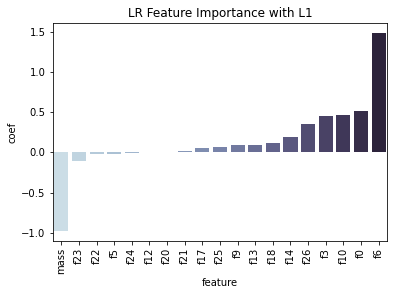

In [39]:
feat_coef = []
feat = zip(baseline.X_train.columns, baseline.model.coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_baseline = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_baseline, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with L1')
plt.show()

### Eliminated Features from L1 Regularization

In [40]:
list( feat_coef.loc[feat_coef['coef']==0, 'feature'] )

['f1', 'f2', 'f4', 'f7', 'f8', 'f11', 'f15', 'f16', 'f19']

#### See if ElasticNet helps with overfitting  features 'mass' and 'f6'

In [41]:
baseline.model = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=0.001, solver='saga', random_state=12343)
print( 'ElasticNet Training Accuracy =', round( baseline.prepare_and_train()['accuracy'], 4) )
print( 'ElasticNet Test Accuracy =', round( baseline.test()['accuracy'], 4) )

ElasticNet Training Accuracy = 0.8367
ElasticNet Test Accuracy = 0.8368


#### Features 'mass' and 'f6' are most important even with some L2 regularization

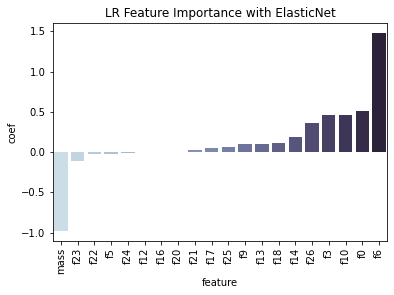

In [42]:
feat_coef = []
feat = zip(baseline.X_train.columns, baseline.model.coef_[0])
[feat_coef.append([i,j]) for i,j in feat]
feat_coef = pd.DataFrame(feat_coef, columns = ['feature','coef'])
top_feat_baseline = feat_coef.loc[abs(feat_coef['coef'])>0].sort_values(by='coef')

feat_plot = sns.barplot(data=top_feat_baseline, x='feature', y='coef', palette = "ch:s=.25,rot=-.25")
plt.xticks(rotation=90)
plt.title('LR Feature Importance with ElasticNet')
plt.show()

In [43]:
list( feat_coef.loc[feat_coef['coef']==0, 'feature'] )

['f1', 'f2', 'f4', 'f7', 'f8', 'f11', 'f15', 'f19']

## Neural Network Modeling

In [56]:
NN = NNClassificationModeling(df,'# label',
                           StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12343),
                           None,
                           None,
                           StandardScaler(), beta=2)

NN.prepare()

In [61]:
NN.model = tf.keras.Sequential() # model object

NN.model.add( tf.keras.layers.Input( shape=(NN.X_train.shape[1],) ) )
# specify data shape for first input layer
# columns (features) only, # rows specified by batch size later in fit() 

NN.model.add( tf.keras.layers.Dense(200, activation = 'relu') )
# add these layers sequentially with decreasing # neurons
NN.model.add( tf.keras.layers.Dense(50, activation = 'relu') )

NN.model.add( tf.keras.layers.Dense(1, activation = 'sigmoid') )
# Final layer, Regression Output
# For Classification, use activation = 'sigmoid' or 'softmax' for Final layer

NN.model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
# Have to compile model after specifying layers

NN.train(batch = 100000, epoch=40)

Epoch 1/40
49/49 [==============================] - 18s 348ms/step - loss: 0.4222 - accuracy: 0.8047 - val_loss: 0.3486 - val_accuracy: 0.8425
Epoch 2/40
49/49 [==============================] - 12s 242ms/step - loss: 0.3350 - accuracy: 0.8471 - val_loss: 0.3245 - val_accuracy: 0.8517
Epoch 3/40
49/49 [==============================] - 10s 208ms/step - loss: 0.3186 - accuracy: 0.8538 - val_loss: 0.3120 - val_accuracy: 0.8566
Epoch 4/40
49/49 [==============================] - 11s 231ms/step - loss: 0.3073 - accuracy: 0.8580 - val_loss: 0.3020 - val_accuracy: 0.8602
Epoch 5/40
49/49 [==============================] - 13s 271ms/step - loss: 0.2993 - accuracy: 0.8608 - val_loss: 0.2957 - val_accuracy: 0.8627
Epoch 6/40
49/49 [==============================] - 12s 248ms/step - loss: 0.2941 - accuracy: 0.8630 - val_loss: 0.2915 - val_accuracy: 0.8645
Epoch 7/40
49/49 [==============================] - 11s 232ms/step - loss: 0.2902 - accuracy: 0.8650 - val_loss: 0.2880 - val_accuracy: 0.8663

{'matrix': array([[2109394,  339991],
        [ 247012, 2203603]], dtype=int64),
 'accuracy': 0.8802034693877551,
 'precision': 0.8663344071420203,
 'recall': 0.8992040773438504,
 'f1': 0.8824632689581072,
 'f2': 0.8924321082671434}

In [62]:
NN.test()

{'matrix': array([[903359, 146377],
        [105834, 944430]], dtype=int64),
 'accuracy': 0.8798995238095239,
 'precision': 0.8658085252478211,
 'recall': 0.8992310504787367,
 'f1': 0.8822033458955822,
 'f2': 0.892341695164822}

In [58]:
%load_ext tensorboard

In [59]:
%tensorboard --logdir logs